In [1]:
import theme
theme.load_style()

In [2]:
import sympy as sp
sp.init_printing()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Lesson 16: The Method of Manufactured Solutions

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a>

This lecture by Tim Fuller is licensed under the
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  All code examples are also licensed under the [MIT license](http://opensource.org/licenses/MIT).

# Validation and Verification

## Validation Question
How do we know if the equations we have been solving are the right equations?

* Compare with data or with more sophisticated models.

## Verification Question
How do we know that we are solving the equations right?

* Compare the approximate solution with an exact solution whenever possible.  Otherwise, perform a variety of "sanity checks".  One such sanity check is the method of manufactured solutions.

# Method of Manufactured Solutions (MMS)

The method of manufactured solutions is a straightforward, yet powerful, method to verify that the finite element equations are being solved correctly.  In the MMS, we start with a "manufactured solution" $u$ and determine the form of the sourcing functions required to produce the solution by applying the governing equations to it.  The sourcing functions are then applied to the code and solution checked.

For example, consider the following boundary value problem

$$
\frac{d\sigma}{dx} + b = 0
$$
$$u(0) = 0$$
$$\sigma(L)=0$$

Let $\sigma = E\epsilon$ (linear elasticity) and suppose $u = f(x)$.  Applying the governing equations to $u$ we get

$$
\frac{d\sigma}{dx} + b = E\frac{d^2f}{dx^2} + b = 0 
\quad \longrightarrow \quad b = -E\frac{d^2f}{dx^2}
$$

Enforcing boundary conditions supplies additional constraints on $f$:

$$f(0) = 0$$
$$E\frac{df}{dx}=0$$

Other constraints (as needed) can be imposed on $f$.

## Example

Let $u = u_0 + u_1 x + u_2 x^2 + u_2 x^3$.  The boundary conditions require that

$$u(0) = u_0 = 0$$
$$\sigma(L) = E\frac{du}{dx} = 
E\frac{d}{dx}\left(u_0 + u_1 x + u_2 x^2 + u_2 x^3\right) = 0$$

We have two equations, but three unknowns.  We choose the third equation by arbitrarily scaling the displacement at L to 1

$$u(L) = u_0 + u_1 L + u_2 L^2 + u_3 L^3 = 1$$

We solve the preceding equations below using sympy

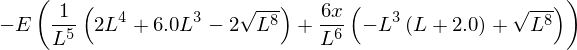

In [43]:
# Manufactured solution
uL = 1
x, L, b, s, E = sp.symbols("x L b sigma E")
u0, u1, u2 = sp.symbols("u0 u1 u2")
a = u0 + u1 * x ** 2 + u2 * x ** 3
eps = sp.diff(a, x)
sig = E * eps * (eps + 2.) / (2. * eps + 2.)
coeffs = sp.solve([a.subs(x, 0), sig.subs(x, L), a.subs(x, L) - uL], 
                  (u0, u1, u2))
coeffs = dict(zip((u0, u1, u2), coeffs[0]))
ua = a.subs(coeffs)
eps = ua.diff(x)
sig = E * eps
b = -sig.diff(x)
b

Yuck!  We now use the $b$ previously determined as an input to the simple linear FE program below to verify that we get back the manufactured solution $u$.

In [20]:
ROOT3 = sqrt(3.)
def wundee(xa, xb, num_elem, E, q):
    """Solves
 
      ds                            du
      -- + q = 0, where s = Ee, e = --
      dx                            dx
      
      subject to
      
      u(0) = 0, s(L) = 0
      
    Parameters
    ----------
    xa, xb : real
        Origin and end of bar
    num_elem : int
        Number of elements
    E : real
        Young's modulus
    q : callable
        Body force per unit area

    Returns
    -------
    X, u : array
        Nodal coordinates and displacements

    """
    # Linear 1D mesh
    n = num_elem + 1
    X = linspace(xa, xb, n)
    connect = array([[i, i+1] for i in range(num_elem)])

    # Global stiffness and force
    K = zeros((n, n))
    F = zeros(n)

    # Shape functions and derivatives, Jacobian
    N = lambda xi: array([1 - xi, 1 + xi]) / 2.
    dN = lambda xi: array([-1., 1.]) / 2.
    Jac = lambda xi, xc: dot(dN(xi), xc)
    x = lambda xi, xc: xc[0] + (xc[1] - xc[0]) / 2. * (1. + xi)

    # assemble global stiffness
    for (e, nodes) in enumerate(connect):
        np = len(nodes)
        xc = X[nodes]
        ke = zeros((2, 2))
        fe = zeros(2)
        for xi in (-1./ROOT3, 1./ROOT3):
            # Convert shape function derivatives to derivatives
            # wrt global coords
            J = Jac(xi, xc)  
            dNdx = dN(xi) / J
            ke += E * J * outer(dNdx, dNdx)
            fe += q(x(xi, xc)) * N(xi) * J

        # add contributions to global matrices
        for a in range(np):
            I = nodes[a]
            F[I] += fe[a]
            for b in range(np):
                J = nodes[b]
                K[I, J] += ke[a, b]

    # Apply boundary conditions
    K[0,0] = 1e30
    F[0] = 0.
    u = linalg.solve(K, F)

    return X, u

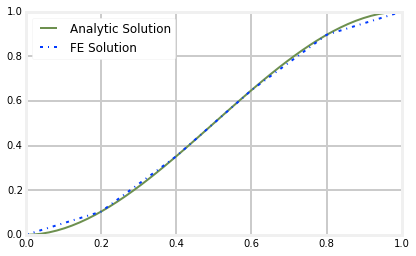

In [53]:
xa, xb, n, E_ = 0., 1., 5, 10
xc = linspace(xa, xb)
plot(xc, sp.lambdify(x, ua.subs({E: E_, L: xb}))(xc), 
     lw=2, label='Analytic Solution')

q = sp.lambdify(x, b.subs({E: E_, L: xb}))
xp, u = wundee(xa, xb, n, E_, q)
plot(xp, u, '-.', lw=2, label='FE Solution')
legend(loc='best');